# Subword Information for Authorship Attribution:Deep learning approach

In [1]:
from __future__ import print_function

In [2]:
import os
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2021-10-17 11:07:49.828065: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-17 11:07:49.828088: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11044044657346271307
]


2021-10-17 11:07:50.597153: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-17 11:07:50.631836: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-17 11:07:50.632537: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-17 11:07:50.632588: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such 

In [3]:
# Liberies
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [4]:
import re
import sys
import pandas as pd
import numpy as np
import string
from sklearn import metrics

In [5]:
# statistics
from scipy import sparse, stats

In [6]:
# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_selection import chi2
import chardet
from collections import Counter
import itertools

In [7]:
# Plot
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
# display plots inline
%matplotlib inline

In [8]:
sns.set_style("whitegrid")
import altair as alt

In [9]:
# scikit-sklearn
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, make_scorer, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold

from sklearn.metrics import precision_recall_fscore_support as score

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OneHotEncoder,MultiLabelBinarizer
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import gensim
import scikitplot.plotters as skplt

In [10]:
# deep learning libraries
from tensorflow import keras
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint, Callback,CSVLogger
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint, Callback,CSVLogger

In [11]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize 
from string import punctuation
# from gensim.models import KeyedVectors
from nltk.stem import SnowballStemmer
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
from sklearn.feature_selection import chi2
import chardet
from collections import Counter
import itertools
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import KFold

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Conv1D
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate, Layer
from tensorflow.keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
# from tensorflow.keras.engine import Layer
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

In [13]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric"""
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric."""
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision + recall + K.epsilon()))

# ROC AUC metrics
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

In [14]:
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Text preprocessing

In [15]:
# Remove newlines & Tabs
def remove_newlines_tabs(text):
    formatted_text = text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ').replace('. com', '.com')
    return formatted_text

# Strip HTML Tags
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    # Get all the text other than html tags.
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

# Remove Links
def remove_links(text):
    # Removing all the occurrences of links that starts with https
    remove_https = re.sub(r'http\S+', '', text)
    # Remove all the occurrences of text that ends with .com
    remove_com = re.sub(r"\ [A-Za-z]*\.com", " ", remove_https)
    return remove_com

# Remove Whitespaces
def remove_whitespace(text):
    pattern = re.compile(r'\s+') 
    Without_whitespace = re.sub(pattern, ' ', text)
    # There are some instances where there is no space after '?' & ')', 
    # So I am replacing these with one space so that It will not consider two words as one token.
    text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
    return text

In [16]:
# Remove Accented Characters
def accented_characters_removal(text):
    # Remove accented characters from text using unidecode.
    # Unidecode() - It takes unicode data & tries to represent it to ASCII characters. 
    text = unidecode.unidecode(text)
    return text

# Case Conversion
def lower_casing_text(text):
    # Convert text to lower case
    # lower() - It converts all upperase letter of given string to lowercase.
    text = text.lower()
    return text

# Reducing repeated characters and punctuations
def reducing_incorrect_character_repeatation(text):
    # Pattern matching for all case alphabets
    pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)
    
    # Limiting all the  repeatation to two characters.
    text_formatted = pattern_alpha.sub(r"\1\1", text) 
    
    # Pattern matching for all the punctuations that can occur
    punct_pattern = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')
    
    # Limiting punctuations in previously formatted string to only one.
    all_formatted = punct_pattern.sub(r'\1', text_formatted)
    
    # The below statement is replacing repeatation of spaces that occur more than two times with that of one occurrence.
    final_pattern = re.sub(' {2,}',' ', all_formatted)
    return final_pattern

# Contractions
CONTRACTION_MAP = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have",
}
# The code for expanding contraction words
def expand_contractions(text, contraction_mapping =  CONTRACTION_MAP):
    # Tokenizing text into tokens.
    list_Of_tokens = text.split(' ')

    # Checking for whether the given token matches with the Key & replacing word with key's value.
    # Check whether Word is in lidt_Of_tokens or not.
    for Word in list_Of_tokens: 
        # Check whether found word is in dictionary "Contraction Map" or not as a key. 
         if Word in CONTRACTION_MAP: 
                # If Word is present in both dictionary & list_Of_tokens, replace that word with the key value.
                list_Of_tokens = [item.replace(Word, CONTRACTION_MAP[Word]) for item in list_Of_tokens]
                
    # Converting list of tokens to String.
    String_Of_tokens = ' '.join(str(e) for e in list_Of_tokens) 
    return String_Of_tokens

# Remove Special Characters
def removing_special_characters(text):
    # The formatted text after removing not necessary punctuations.
    Formatted_Text = re.sub(r"[^a-zA-Z0-9:$-,%.?!]+", ' ', text) 
    # In the above regex expression,I am providing necessary set of punctuations that are frequent in this particular dataset.
    return Formatted_Text

In [17]:
stopWords = set(stopwords.words('english'))
def cleanString(text):
#   text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r" \n ", " ", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text) # remove possessive pronoun terminations:
    text = re.sub(r"\'ve", "have", text)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    # Remove stop words
    stops = {'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", 
              "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's",
              'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 
              'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 
              'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 
              'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 
              'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 
              'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over',
              'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all',
              'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only',
              'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should',
              "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't",
              'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', 
              "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 
              'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't" }
    text = [w for w in text if not w in stops]
    
    #     # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    text = [w.translate(table) for w in text]
    
# #     ## Stemming (remove -ing, -ly, ...)
    porter = PorterStemmer()
    text = [porter.stem(word) for word in text]
    
    ## Lemmatizer
    lemma = WordNetLemmatizer()
    text = [lemma.lemmatize(word) for word in text]
    
    text = " ".join(text)
    
    return text

# Load dataset

In [36]:
from sklearn.datasets import fetch_20newsgroups
news = fetch_20newsgroups(subset='all')

print("Number of articles: " + str(len(news.data)))
print("Number of diffrent categories: " + str(len(news.target_names)))

Number of articles: 18846
Number of diffrent categories: 20


In [37]:
print("\n".join(news.data[10].split("\n")[:]))

From: sandvik@newton.apple.com (Kent Sandvik)
Subject: Re: 14 Apr 93   God's Promise in 1 John 1: 7
Organization: Cookamunga Tourist Bureau
Lines: 17

In article <1qknu0INNbhv@shelley.u.washington.edu>, > Christian:  washed in
the blood of the lamb.
> Mithraist:  washed in the blood of the bull.
> 
> If anyone in .netland is in the process of devising a new religion,
> do not use the lamb or the bull, because they have already been
> reserved.  Please choose another animal, preferably one not
> on the Endangered Species List.  

This will be a hard task, because most cultures used most animals
for blood sacrifices. It has to be something related to our current
post-modernism state. Hmm, what about used computers?

Cheers,
Kent
---
sandvik@newton.apple.com. ALink: KSAND -- Private activities on the net.



In [44]:
# newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
df = pd.DataFrame([news.data, news.target.tolist()]).T
df.columns = ['text', 'target']

In [45]:
targets = pd.DataFrame(news.target_names)
targets.columns=['title']

In [46]:
out = pd.merge(df, targets, left_on='target', right_index=True)

In [48]:
out['date'] = pd.to_datetime('now')
data_dir = 'data/'
out.to_csv(data_dir + 'newsgroup.csv')

In [51]:
data = pd.read_csv(data_dir + "newsgroup.csv")
data.head(2)

,Unnamed: 0,text,target,title,date
0,0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10,rec.sport.hockey,2021-10-17 09:37:52.656656
1,7,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,10,rec.sport.hockey,2021-10-17 09:37:52.656656


In [59]:
import keras
from keras.datasets import reuters
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

In [60]:
print('# of Training Samples: {}'.format(len(x_train)))
print('# of Test Samples: {}'.format(len(x_test)))

num_classes = max(y_train) + 1
print('# of Classes: {}'.format(num_classes))

# of Training Samples: 8982
# of Test Samples: 2246
# of Classes: 46


In [61]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

In [64]:
index_to_word = {}
for key, value in word_index.items():
    index_to_word[value] = key

In [65]:
print(' '.join([index_to_word[x] for x in x_train[0]]))
print(y_train[0])

the wattie nondiscriminatory mln loss for plc said at only ended said commonwealth could 1 traders now april 0 a after said from 1985 and from foreign 000 april 0 prices its account year a but in this mln home an states earlier and rise and revs vs 000 its 16 vs 000 a but 3 psbr oils several and shareholders and dividend vs 000 its all 4 vs 000 1 mln agreed largely april 0 are 2 states will billion total and against 000 pct dlrs
3


In [ ]:
from keras.datasets import reuters
(x_train, y_train), (x_test, y_test) = reuters.load_data(path="reuters.npz", num_words=None, 
                                                         skip_top=0,maxlen=None, test_split=0.2, 
                                                         seed=113, start_char=1,oov_char=2, 
                                                         index_from=3)

In [17]:
test = pd.read_csv(data_dir + "test.csv", encoding="utf-8")
test = test[test['content'].isnull()==False] 
test.dropna(subset=['content'], inplace=True)
test.dropna(subset=['userId'], inplace=True)
test.head(3)

,reviewId,userId,content
0,584817,dbdumonteil,The script writers have transposed the action ...
1,462842,martinhafer,ELECTION NIGHT is a clever film about racism ....
2,498314,poolandrews,Halloween : The Curse of Michael Myers starts ...


In [18]:
print("Lengths Train/Test: {} / {}".format(len(train),len(test))) #44620

Lengths Train/Test: 49578 / 12395


In [19]:
def fit_encoder(encoder,corpus):
    start = time.time()
    encoder.fit(corpus)
    print("Encoder trained: "+str(int(time.time() - start))+"s")

In [20]:
train['content'] = [s.lower() for s in train['content']]
test['content'] = [s.lower() for s in test['content']]

In [21]:
train.head(2)

,reviewId,userId,content
0,498645,poolandrews,the film opens with the on screen paragraph ' ...
1,486968,gridoon,40 carats is a surprisingly good movie . whi...


In [22]:
test.head(2)

,reviewId,userId,content
0,584817,dbdumonteil,the script writers have transposed the action ...
1,462842,martinhafer,election night is a clever film about racism ....


In [23]:
print("Lengths Train/Test: {} / {}".format(len(train),len(test))) #44620

Lengths Train/Test: 49578 / 12395


In [24]:
list_sentences_train = train["content"].fillna("__empty__").values
list_sentences_test = test["content"].fillna("__empty__").values

# Bytes-pair encoding with ngram models
 * http://ethen8181.github.io/machine-learning/keras/text_classification/keras_subword_tokenization.html

In [12]:
from collections import Counter

try:
    from typing import Dict, Iterable, Callable, List, Any, Iterator
except ImportError:
    pass

from nltk.tokenize import wordpunct_tokenize
from tqdm import tqdm
import toolz
import json

DEFAULT_EOW = '__eow'
DEFAULT_SOW = '__sow'
DEFAULT_UNK = '__unk'
DEFAULT_PAD = '__pad'

class Encoder:
    """ Encodes white-space separated text using byte-pair encoding.  See https://arxiv.org/abs/1508.07909 for details.
    """

    def __init__(self, vocab_size=8192, pct_bpe=0.2, word_tokenizer=None,
                 silent=True, ngram_min=2, ngram_max=2, required_tokens=None, strict=False, 
                 EOW=DEFAULT_EOW, SOW=DEFAULT_SOW, UNK=DEFAULT_UNK, PAD=DEFAULT_PAD):
        if vocab_size < 1:
            raise ValueError('vocab size must be greater than 0.')

        self.EOW = EOW
        self.SOW = SOW
        self.eow_len = len(EOW)
        self.sow_len = len(SOW)
        self.UNK = UNK
        self.PAD = PAD
        self.required_tokens = list(set(required_tokens or []).union({self.UNK, self.PAD}))
        self.vocab_size = vocab_size
        self.pct_bpe = pct_bpe
        self.word_vocab_size = max([int(vocab_size * (1 - pct_bpe)), len(self.required_tokens or [])])
        self.bpe_vocab_size = vocab_size - self.word_vocab_size
        self.word_tokenizer = word_tokenizer if word_tokenizer is not None else wordpunct_tokenize
        self.custom_tokenizer = word_tokenizer is not None
        self.word_vocab = {}  # type: Dict[str, int]
        self.bpe_vocab = {}  # type: Dict[str, int]
        self.inverse_word_vocab = {}  # type: Dict[int, str]
        self.inverse_bpe_vocab = {}  # type: Dict[int, str]
        self._progress_bar = iter if silent else tqdm
        self.ngram_min = ngram_min
        self.ngram_max = ngram_max
        self.strict = strict

    def mute(self):
        """ Turn on silent mode """
        self._progress_bar = iter

    def unmute(self):
        """ Turn off silent mode """
        self._progress_bar = tqdm

    def byte_pair_counts(self, words):
        # type: (Encoder, Iterable[str]) -> Iterable[Counter]
        """ Counts space separated token character pairs:
            [('T h i s </w>', 4}] -> {'Th': 4, 'hi': 4, 'is': 4}
        """
        for token, count in self._progress_bar(self.count_tokens(words).items()):
            bp_counts = Counter()  # type: Counter
            for ngram in token.split(' '):
                bp_counts[ngram] += count
            for ngram_size in range(self.ngram_min, min([self.ngram_max, len(token)]) + 1):
                ngrams = [''.join(ngram) for ngram in toolz.sliding_window(ngram_size, token.split(' '))]

                for ngram in ngrams:
                    bp_counts[''.join(ngram)] += count

            yield bp_counts

    def count_tokens(self, words):
        # type: (Encoder, Iterable[str]) -> Dict[str, int]
        """ Count tokens into a BPE vocab """
        token_counts = Counter(self._progress_bar(words))
        return {' '.join(token): count for token, count in token_counts.items()}

    def learn_word_vocab(self, sentences):
        # type: (Encoder, Iterable[str]) -> Dict[str, int]
        """ Build vocab from self.word_vocab_size most common tokens in provided sentences """
        word_counts = Counter(word for word in toolz.concat(map(self.word_tokenizer, sentences)))
        for token in set(self.required_tokens or []):
            word_counts[token] = int(2**63)
        sorted_word_counts = sorted(word_counts.items(), key=lambda p: -p[1])
        return {word: idx for idx, (word, count) in enumerate(sorted_word_counts[:self.word_vocab_size])}

    def learn_bpe_vocab(self, words):
        # type: (Encoder, Iterable[str]) -> Dict[str, int]
        """ Learns a vocab of byte pair encodings """
        vocab = Counter()  # type: Counter
        for token in {self.SOW, self.EOW}:
            vocab[token] = int(2**63)
        for idx, byte_pair_count in enumerate(self.byte_pair_counts(words)):
            for byte_pair, count in byte_pair_count.items():
                vocab[byte_pair] += count

            if (idx + 1) % 10000 == 0:
                self.trim_vocab(10 * self.bpe_vocab_size, vocab)

        sorted_bpe_counts = sorted(vocab.items(), key=lambda p: -p[1])[:self.bpe_vocab_size]
        return {bp: idx + self.word_vocab_size for idx, (bp, count) in enumerate(sorted_bpe_counts)}

    def fit(self, text):
        # type: (Encoder, Iterable[str]) -> None
        """ Learn vocab from text. """
        _text = [l.lower().strip() for l in text]

        # First, learn word vocab
        self.word_vocab = self.learn_word_vocab(_text)

        remaining_words = [word for word in toolz.concat(map(self.word_tokenizer, _text))
                           if word not in self.word_vocab]
        self.bpe_vocab = self.learn_bpe_vocab(remaining_words)

        self.inverse_word_vocab = {idx: token for token, idx in self.word_vocab.items()}
        self.inverse_bpe_vocab = {idx: token for token, idx in self.bpe_vocab.items()}

    @staticmethod
    def trim_vocab(n, vocab):
        # type: (int, Dict[str, int]) -> None
        """  Deletes all pairs below 10 * vocab size to prevent memory problems """
        pair_counts = sorted(vocab.items(), key=lambda p: -p[1])
        pairs_to_trim = [pair for pair, count in pair_counts[n:]]
        for pair in pairs_to_trim:
            del vocab[pair]

    def subword_tokenize(self, word):
        # type: (Encoder, str) -> List[str]
        """ Tokenizes inside an unknown token using BPE """
        end_idx = min([len(word), self.ngram_max])
        sw_tokens = [self.SOW]
        start_idx = 0

        while start_idx < len(word):
            subword = word[start_idx:end_idx]
            if subword in self.bpe_vocab:
                sw_tokens.append(subword)
                start_idx = end_idx
                end_idx = min([len(word), start_idx + self.ngram_max])
            elif len(subword) == 1:
                sw_tokens.append(self.UNK)
                start_idx = end_idx
                end_idx = min([len(word), start_idx + self.ngram_max])
            else:
                end_idx -= 1

        sw_tokens.append(self.EOW)
        return sw_tokens

    def tokenize(self, sentence):
        # type: (Encoder, str) -> List[str]
        """ Split a sentence into word and subword tokens """
        word_tokens = self.word_tokenizer(sentence.lower().strip())

        tokens = []
        for word_token in word_tokens:
            if word_token in self.word_vocab:
                tokens.append(word_token)
            else:
                tokens.extend(self.subword_tokenize(word_token))

        return tokens
    def transform(self, sentences, reverse=False, fixed_length=None):
        # type: (Encoder, Iterable[str], bool, int) -> Iterable[List[int]]
        """ Turns space separated tokens into vocab idxs """
        direction = -1 if reverse else 1
        for sentence in self._progress_bar(sentences):
            encoded = []
            tokens = list(self.tokenize(sentence.lower().strip()))
            for token in tokens:
                if token in self.word_vocab:
                    encoded.append(self.word_vocab[token])
                elif token in self.bpe_vocab:
                    encoded.append(self.bpe_vocab[token])
                else:
                    encoded.append(self.word_vocab[self.UNK])

            if fixed_length is not None:
                encoded = encoded[:fixed_length]
                while len(encoded) < fixed_length:
                    encoded.append(self.word_vocab[self.PAD])

            yield encoded[::direction]

In [65]:
# list_sentences_train[0:2]

In [25]:
vocabulary = 50000
encoder = Encoder(vocabulary, ngram_max=5)
corpus = list_sentences_train
fit_encoder(encoder,corpus)

Encoder trained: 13s


In [26]:
list_tokenized_train = list(encoder.transform(list_sentences_train))
list_tokenized_test = list(encoder.transform(list_sentences_test))

In [27]:
cutout_percentile = 99.0

In [28]:
sizes = [len(x) for x in list_tokenized_train + list_tokenized_test]
max_size = int(np.percentile(sizes,cutout_percentile))
max_features = max([max(x) for x in list_tokenized_train+list_tokenized_test])+1

In [29]:
print("Vocabulary: {}, Max Entry Size: {}".format(max_features,max_size))

Vocabulary: 49999, Max Entry Size: 1163


In [30]:
x_train = sequence.pad_sequences(list_tokenized_train, maxlen=max_size)
x_test = sequence.pad_sequences(list_tokenized_test, maxlen=max_size)

# Custom Callback

In [31]:
class PlotModel(Callback):
    def set_params_(self, model_type, checkpoint_path, dataset, 
                   batch_size, plot_per_batch,
                   dictionary_size, max_review_length, 
                   best_model_monitor, early_stop_monitor):
        self.path = checkpoint_path
        self.model_type = model_type
        self.dataset = dataset
        self.batch_size = batch_size
        self.dictionary_size = dictionary_size
        self.max_review_length = max_review_length
        self.best_model_monitor = best_model_monitor
        self.early_stop_monitor = early_stop_monitor
        self.plot_per_batch = plot_per_batch
    
    def get_monitor_ticks(self):
        if self.best_model_monitor == "val_acc":
            bm_ind = np.argmax(self.val_acc)
        else:
            bm_ind = np.argmin(self.val_losses)
        
        if self.early_stop_monitor == "val_acc":
            es_ind = np.argmax(self.val_acc)
        else:
            es_ind = np.argmin(self.val_losses)
        return [bm_ind, es_ind]
    
    def plot(self, save):
        clear_output(wait=True)
        fig = plt.figure()
        plt.grid(True)
        plt.plot(self.x, self.acc, '--', label="acc")
        plt.plot(self.x, self.val_acc, label="val_acc")
        plt.plot(self.x, self.losses, '--', label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        bm_ind, es_ind = self.get_monitor_ticks()
        plt.axvline(x=self.x[bm_ind],alpha=0.6,color="green", linestyle='--')
        plt.axvline(x=self.x[es_ind],alpha=0.6,color="red", linestyle='--')
        title = "{}: accuracy & loss for {} (length:{}, val acc/loss: {:.4f}/{:.4f})"
        title = title.format(self.model_type,self.dataset,self.max_review_length,max(self.val_acc),min(self.val_losses))
        plt.title(title)
        plt.legend(['acc: train', 'acc: validation','loss: train', 'loss: validation'], loc='upper left')
        plt.show()
        if save:
            fig.savefig(self.path+"-figure.png")
            
    def on_train_begin(self, logs={}):
        self.i = 1
        self.x = [0]
        self.acc = [0]
        self.val_acc = [0]
        self.losses = [1]
        self.val_losses = [1]
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        if 'acc' in logs  and 'loss' in logs:
            self.logs.append(logs)
            self.x.append(self.i)
            self.acc.append(logs.get('acc'))
            self.losses.append(logs.get('loss'))
            if "val_acc" in logs and "val_loss" in logs:
                self.val_acc.append(logs.get('val_acc'))
                self.val_losses.append(logs.get('val_loss'))
            else:
                self.val_acc.append(self.val_acc[len(self.val_acc)-1])
                self.val_losses.append(self.val_losses[len(self.val_losses)-1])
            self.i += 1
            self.plot(False)
        else:
            keys = []
            for k in ['acc', 'val_acc', 'loss', 'val_loss']:
                if k not in logs:
                    keys.append(k)
            print(("Missing parameters",keys,logs))
    
    def on_batch_end(self, batch, logs={}):
        if batch%self.plot_per_batch != 0:
            return
        else:
            self.on_epoch_end(batch, logs)
    
    def on_train_end(self, epoch, logs={}):
        self.plot(True)

# Parameter definition

In [32]:
num_of_classes = 60

optimizer = 'adam'
loss = 'categorical_crossentropy'
embed_size = 128
dropout_p = 0.5

batch_size = 64
epochs = 20
es_patience = 5

In [33]:
model_type = "model1"
file_path =model_type+".weights_base.best.hdf5"

In [34]:
number_of_plots = 200
number_of_batches_per_epoch = len(x_train)/batch_size
plot_per_batch = int(number_of_batches_per_epoch/(number_of_plots/epochs))
if plot_per_batch == 0:
    plot_per_batch = 1
plot_per_batch

77

In [35]:
from keras.callbacks import CSVLogger
plotter = PlotModel()
plotter.set_params_(model_type, 
                    model_type+"-checkpoint-path", "bpe-{}k".format(int(vocabulary/1000)), 
                    batch_size, plot_per_batch,
                    vocabulary, max_size, 
                   'val_loss', 'val_loss')

checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
earlyStopping = EarlyStopping(monitor="val_loss", mode="max", patience=es_patience)

csvloggerpath = data_dir + 'movie_log.csv'
csv_logger = CSVLogger(csvloggerpath, append=True, separator=';')

callbacks_list = [plotter, checkpoint, earlyStopping, csv_logger]

# Get class label

In [36]:
label_encoder = LabelEncoder()
# Encode labels in column 'userId'. 
integer_encoded = label_encoder.fit_transform(train["userId"].values) 
test_encoded = label_encoder.transform(test["userId"].values)
from keras.utils import to_categorical
y_train = to_categorical(integer_encoded)
y_test = to_categorical(test_encoded)

# Several deep learning approach 
  * CNN maxpooling with BiLSTM

In [34]:
def build_model(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, 
                 dense_units=128, dr=0.0,conv_size=32):

    inp = Input(shape = (max_size,))
    x = Embedding(max_features, embed_size)(inp)
    
    x1 = SpatialDropout1D(spatial_dr)(x)

    x_gru = Bidirectional(GRU(units, return_sequences = True))(x1)
    x_lstm = Bidirectional(LSTM(units, return_sequences = True))(x1)
    
    x1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool1_gru = GlobalAveragePooling1D()(x1)
    max_pool1_gru = GlobalMaxPooling1D()(x1)

    x3 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool3_gru = GlobalAveragePooling1D()(x3)
    max_pool3_gru = GlobalMaxPooling1D()(x3)

    x_lstm = Bidirectional(LSTM(units, return_sequences = True))(x1)
    x1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool1_lstm = GlobalAveragePooling1D()(x1)
    max_pool1_lstm = GlobalMaxPooling1D()(x1)

    x3 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool3_lstm = GlobalAveragePooling1D()(x3)
    max_pool3_lstm = GlobalMaxPooling1D()(x3)
    
    x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool3_gru, max_pool3_gru,
                    avg_pool1_lstm, max_pool1_lstm, avg_pool3_lstm, max_pool3_lstm])
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    
    x = Dense(num_of_classes, activation = "softmax")(x)
    model = Model(inputs = inp, outputs = x)
    
    # compiler
    model.compile(loss=loss, optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
        
    # K-fold cross-valdiation and fitting
    
    k = 5
    num_validation_sample = len(x_train)//k

    for i in range(k):
        print("-----------------------------")
        print('Processing fold #', i)
        print("-----------------------------")
        x_val = x_train[i * num_validation_sample: (i + 1) * num_validation_sample]
        y_val  = y_train[i * num_validation_sample: (i + 1) * num_validation_sample]

        train_x_data = np.concatenate(
                    [x_train[:i * num_validation_sample],
                    x_train[(i + 1) * num_validation_sample:]], axis=0)

        train_y_label = np.concatenate(
                    [y_train[:i * num_validation_sample],
                    y_train[(i + 1) * num_validation_sample:]], axis=0)
            
        history1 = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
                        validation_data=(x_val, y_val), verbose=1, shuffle=True,
                        callbacks = [checkpoint, earlyStopping, csv_logger])  #callbacks=callbacks_list) #
        
    model = load_model(file_path)
    return model

In [35]:
model1 = build_model(lr=1e-3, lr_d=1e-10, units=64, spatial_dr=0.3,kernel_size1=5,kernel_size2=7,dense_units=32, 
                      dr=0.1, conv_size=32)

-----------------------------
Processing fold # 0
-----------------------------
Epoch 1/20
775/775 [==============================] - ETA: 0s - loss: 3.0756 - accuracy: 0.2209
Epoch 00001: val_loss improved from inf to 2.31470, saving model to model1.weights_base.best.hdf5
775/775 [==============================] - 126s 163ms/step - loss: 3.0756 - accuracy: 0.2209 - val_loss: 2.3147 - val_accuracy: 0.3558
Epoch 2/20
775/775 [==============================] - ETA: 0s - loss: 1.6760 - accuracy: 0.5256
Epoch 00002: val_loss improved from 2.31470 to 1.24172, saving model to model1.weights_base.best.hdf5
775/775 [==============================] - 126s 163ms/step - loss: 1.6760 - accuracy: 0.5256 - val_loss: 1.2417 - val_accuracy: 0.6375
Epoch 3/20
775/775 [==============================] - ETA: 0s - loss: 1.1752 - accuracy: 0.6548
Epoch 00003: val_loss did not improve from 1.24172
775/775 [==============================] - 126s 163ms/step - loss: 1.1752 - accuracy: 0.6548 - val_loss: 1.2775

In [36]:
model1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1163)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1163, 128)    6399872     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 1163, 128)    0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 1163, 128)    74496       spatial_dropout1d[0][0]          
_______________________________________________________________________________________

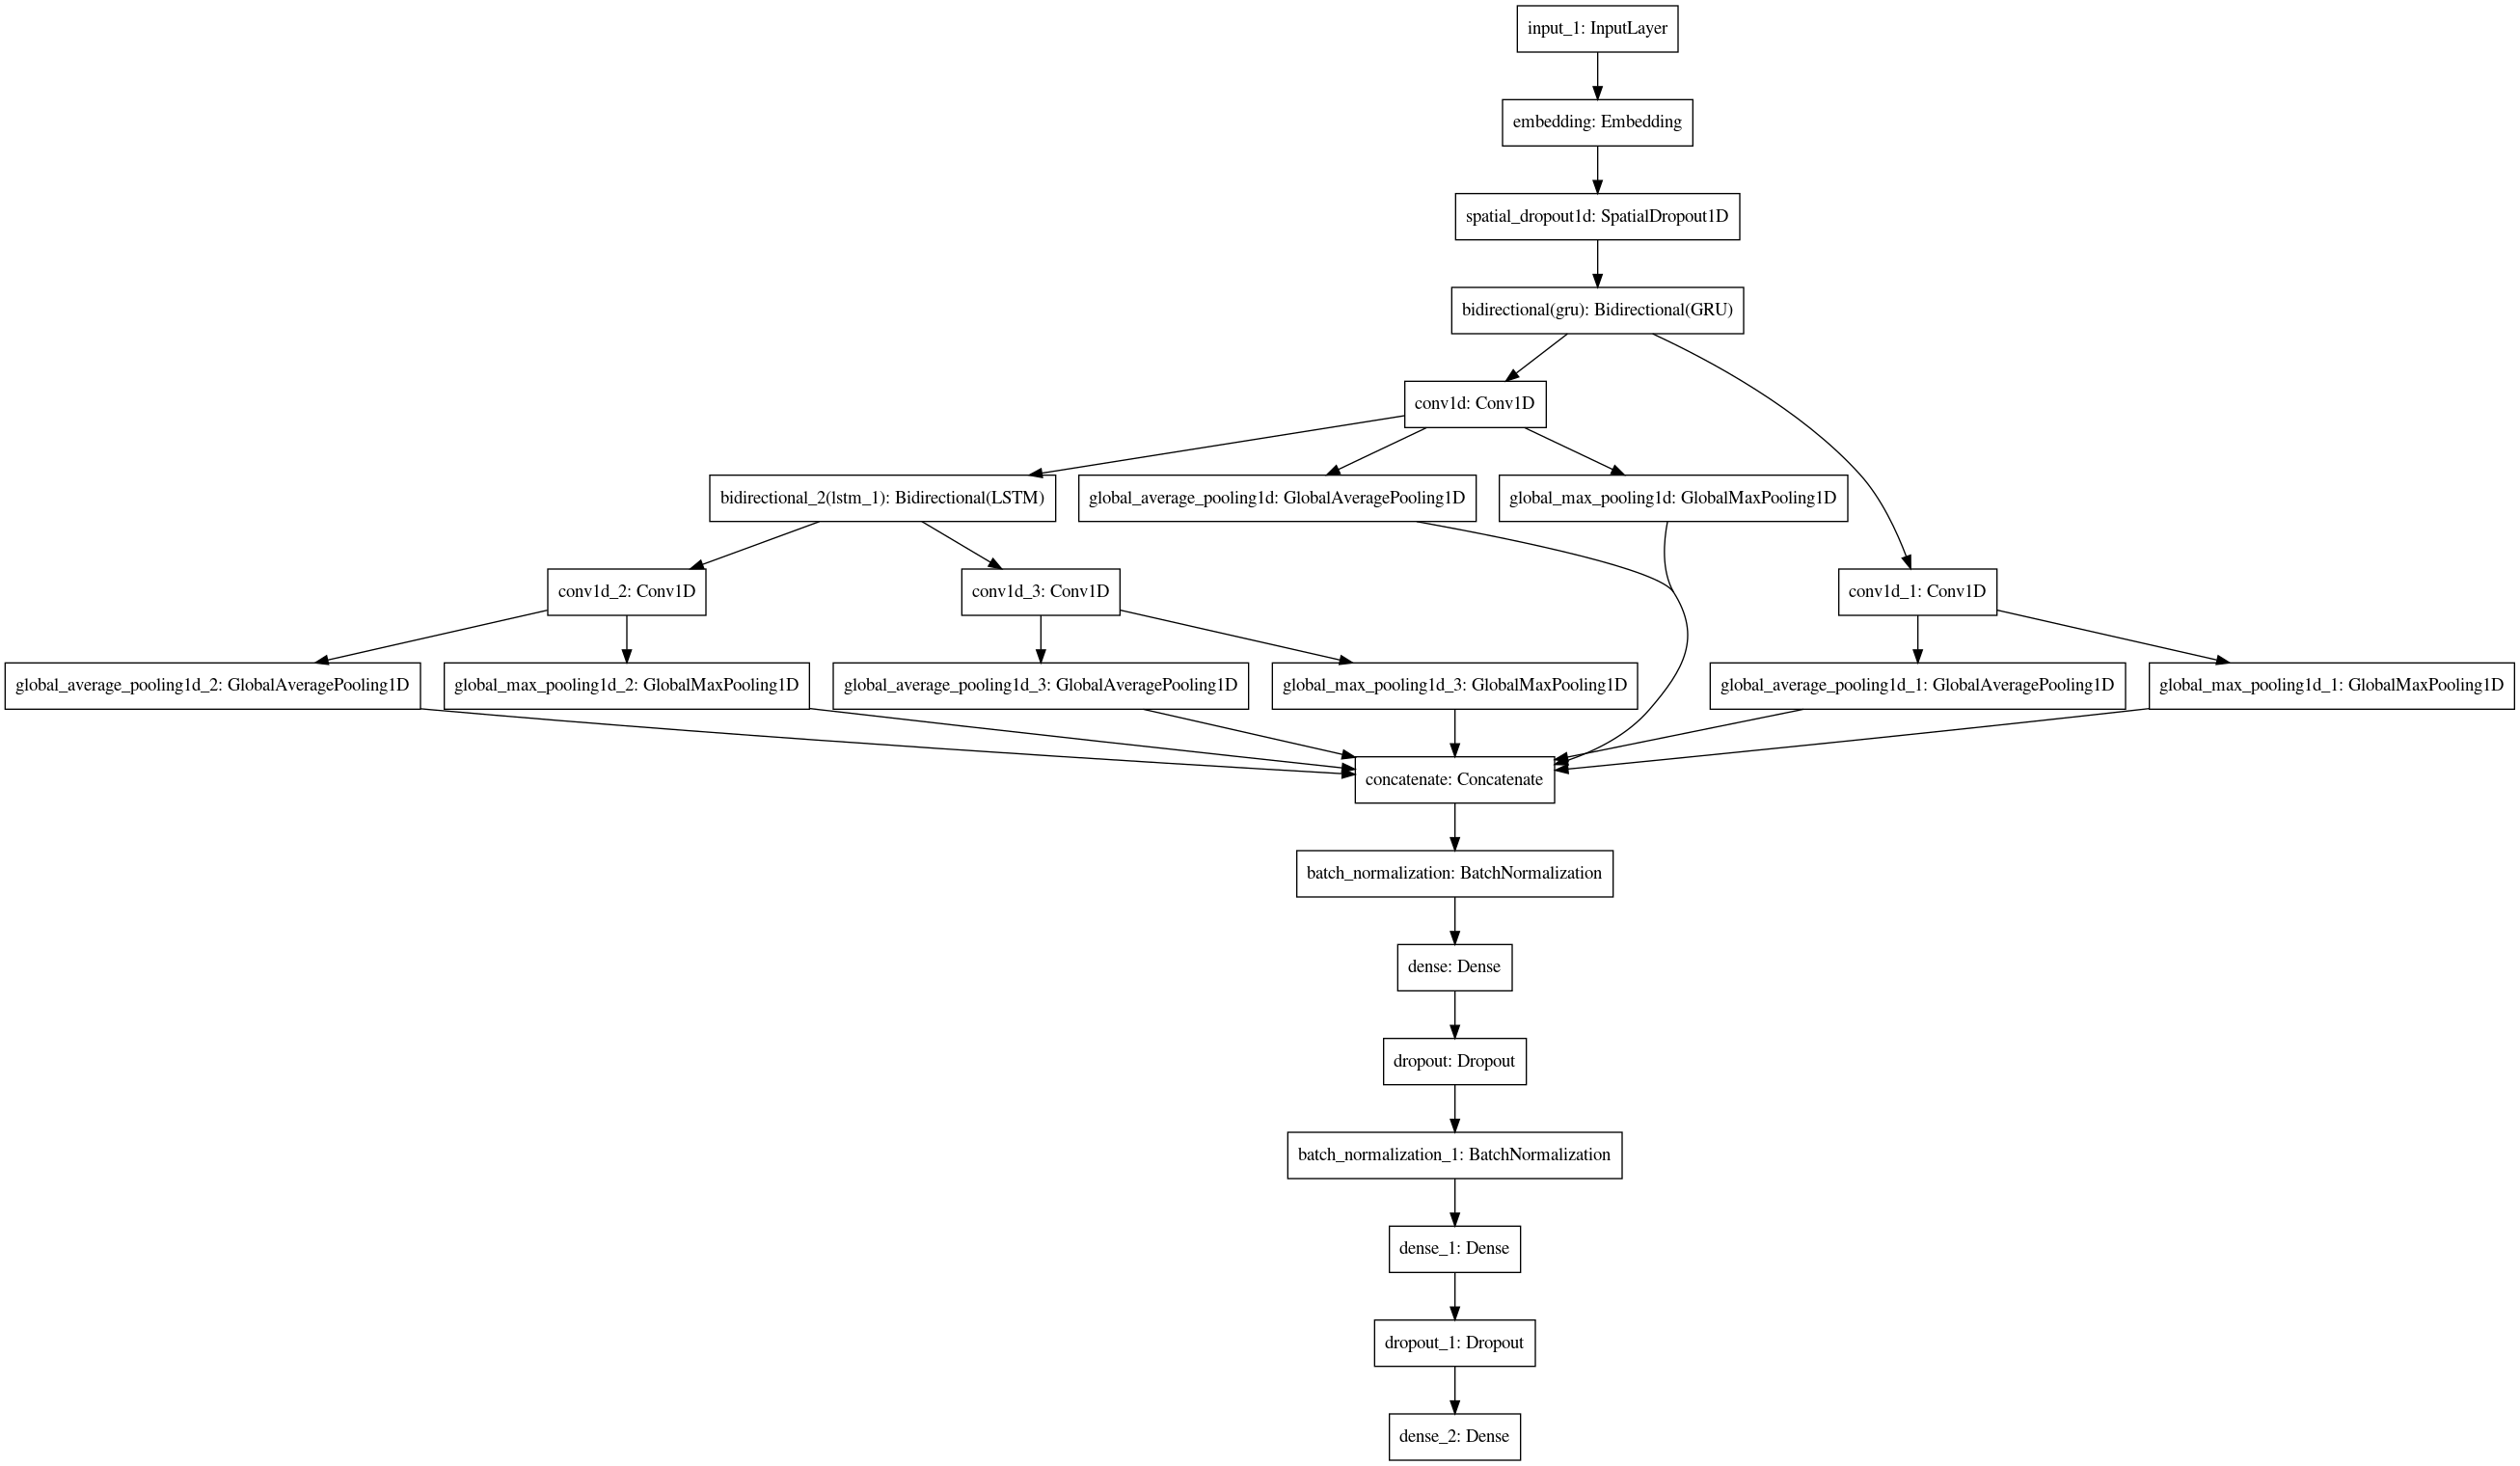

In [37]:
tf.keras.utils.plot_model(model1)

# Evaluate Test dataset on model1

In [38]:
model1.load_weights(file_path)
score = model1.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

388/388 [==============================] - 18s 45ms/step - loss: 0.7409 - accuracy: 0.8595
Test loss: 0.7408877611160278
Test accuracy: 0.8595401644706726


In [39]:
prediction_value = model1.predict(x_test)
predict_class = np.argmax(prediction_value, axis=-1)
ytest=np.argmax(y_test, axis=1)

In [40]:
# Detailed analysis
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(ytest, predict_class))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86       226
           1       0.90      0.79      0.84       197
           2       0.86      0.86      0.86       209
           3       0.75      0.72      0.73       180
           4       0.80      0.66      0.73       200
           5       0.85      0.80      0.83       212
           6       0.96      0.91      0.93       192
           7       0.64      0.81      0.72       200
           8       0.91      0.83      0.86       209
           9       0.99      0.96      0.97       217
          10       0.89      0.86      0.88       177
          11       0.91      0.81      0.86       200
          12       0.96      0.92      0.94       200
          13       0.88      0.90      0.89       207
          14       0.78      0.80      0.79       206
          15       0.60      0.72      0.66       184
          16       0.53      0.89      0.66       207
          17       0.84    

In [41]:
# Confusion matrix for NBSVM Classifier
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [42]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(ytest, predict_class)

Confusion matrix, without normalization
[[173   0   0 ...   0   0   0]
 [  0 155   0 ...   0   0   0]
 [  0   0 180 ...   0   0   1]
 ...
 [  0   0   0 ... 190   0   0]
 [  0   0   0 ...   0 202   0]
 [  0   0   0 ...   0   0 170]]


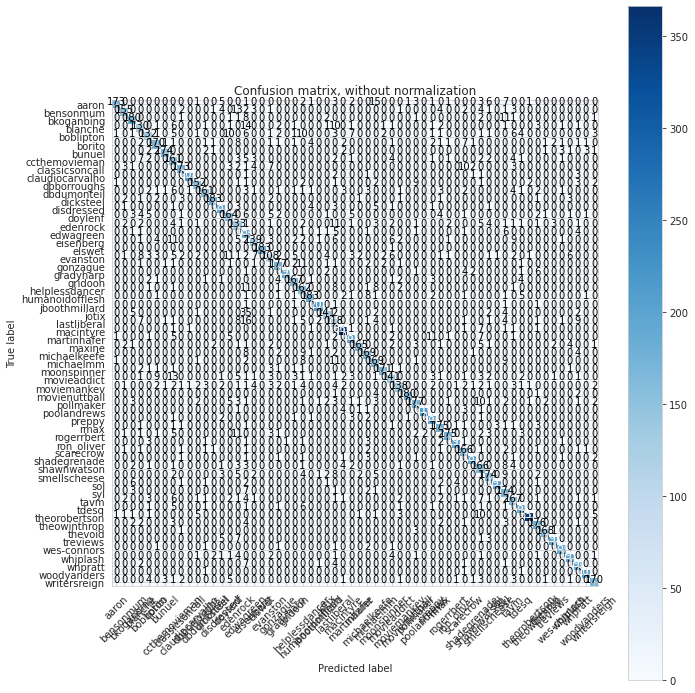

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['aaron', 'bensonmum', 'bkoganbing', 'blanche', 'boblipton',
       'borito', 'bunuel', 'ccthemovieman', 'classicsoncall',
       'claudiocarvalho', 'dbborroughs', 'dbdumonteil', 'dicksteel',
       'disdressed', 'doylenf', 'edenrock', 'edwagreen', 'eisenberg',
       'elswet', 'evanston', 'gonzague', 'gradyharp', 'gridoon',
       'helplessdancer', 'humanoidofflesh', 'jboothmillard', 'jotix',
       'lastliberal', 'macintyre', 'martinhafer', 'maxine',
       'michaelkeefe', 'michaelmm', 'moonspinner', 'movieaddict',
       'moviemankev', 'movienuttball', 'pollmaker', 'poolandrews',
       'preppy', 'rmax', 'rogerrbert', 'ron_oliver', 'scarecrow',
       'shadegrenade', 'shawnwatson', 'smellscheese', 'sol', 'syl',
       'tavm', 'tdesq', 'theorobertson', 'theowinthrop', 'thevoid',
       'treviews', 'wes-connors', 'whiplash', 'whpratt', 'woodyanders',
       'writersreign'],
                title='Confusion matrix, without normalization')

# Model 2

In [44]:
model2 = build_model(lr = 1e-3, lr_d = 1e-10, units = 128,spatial_dr = 0.5, kernel_size1=3, 
                      kernel_size2=3, dense_units=64, dr=0.2, conv_size=32)

-----------------------------
Processing fold # 0
-----------------------------
Epoch 1/20
775/775 [==============================] - ETA: 0s - loss: 3.1244 - accuracy: 0.2112
Epoch 00001: val_loss did not improve from 0.00413
775/775 [==============================] - 149s 192ms/step - loss: 3.1244 - accuracy: 0.2112 - val_loss: 17.0560 - val_accuracy: 0.0153
Epoch 2/20
775/775 [==============================] - ETA: 0s - loss: 1.6787 - accuracy: 0.5293
Epoch 00002: val_loss did not improve from 0.00413
775/775 [==============================] - 149s 192ms/step - loss: 1.6787 - accuracy: 0.5293 - val_loss: 17.3075 - val_accuracy: 0.0289
Epoch 3/20
775/775 [==============================] - ETA: 0s - loss: 1.1999 - accuracy: 0.6545
Epoch 00003: val_loss did not improve from 0.00413
775/775 [==============================] - 149s 192ms/step - loss: 1.1999 - accuracy: 0.6545 - val_loss: 4.6978 - val_accuracy: 0.1744
Epoch 4/20
775/775 [==============================] - ETA: 0s - loss: 0.

# Evaluate Test dataset on model2

In [45]:
model2.load_weights(file_path)
score = model2.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

388/388 [==============================] - 21s 54ms/step - loss: 0.4832 - accuracy: 0.9061
Test loss: 0.48315179347991943
Test accuracy: 0.9060911536216736


In [46]:
prediction_value = model2.predict(x_test)
predict_class = np.argmax(prediction_value, axis=-1)
ytest=np.argmax(y_test, axis=1)

In [47]:
# Detailed analysis
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(ytest, predict_class))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       226
           1       0.87      0.87      0.87       197
           2       0.92      0.88      0.90       209
           3       0.83      0.78      0.81       180
           4       0.81      0.80      0.80       200
           5       0.88      0.91      0.90       212
           6       0.98      0.96      0.97       192
           7       0.89      0.76      0.82       200
           8       0.92      0.91      0.92       209
           9       1.00      0.95      0.97       217
          10       0.87      0.97      0.92       177
          11       0.98      0.81      0.89       200
          12       0.92      0.94      0.93       200
          13       0.86      0.94      0.90       207
          14       0.86      0.83      0.85       206
          15       0.75      0.81      0.78       184
          16       0.81      0.91      0.86       207
          17       0.86    

In [48]:
# Confusion matrix for NBSVM Classifier
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [49]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(ytest, predict_class)

Confusion matrix, without normalization
[[219   0   0 ...   0   0   0]
 [  0 171   0 ...   0   0   0]
 [  0   3 184 ...   0   0   2]
 ...
 [  0   0   0 ... 198   0   0]
 [  0   0   0 ...   0 202   0]
 [  0   0   1 ...   0   0 188]]


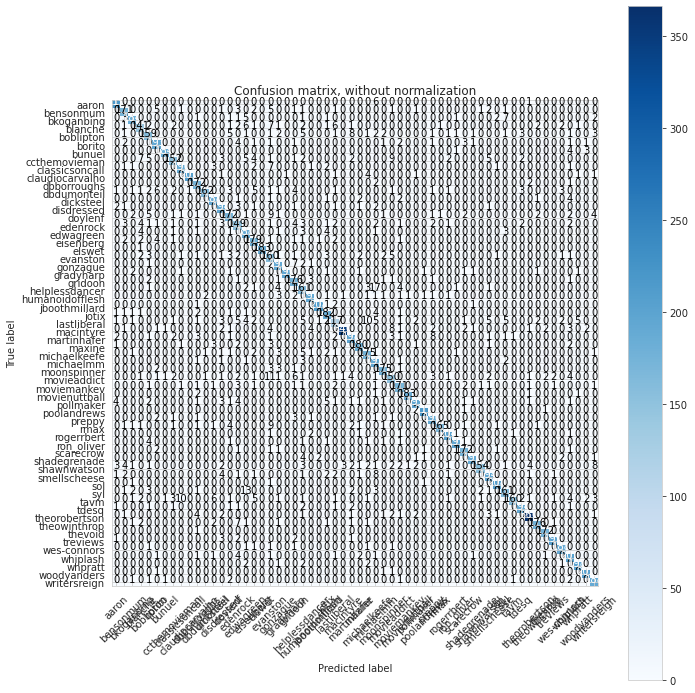

In [50]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['aaron', 'bensonmum', 'bkoganbing', 'blanche', 'boblipton',
       'borito', 'bunuel', 'ccthemovieman', 'classicsoncall',
       'claudiocarvalho', 'dbborroughs', 'dbdumonteil', 'dicksteel',
       'disdressed', 'doylenf', 'edenrock', 'edwagreen', 'eisenberg',
       'elswet', 'evanston', 'gonzague', 'gradyharp', 'gridoon',
       'helplessdancer', 'humanoidofflesh', 'jboothmillard', 'jotix',
       'lastliberal', 'macintyre', 'martinhafer', 'maxine',
       'michaelkeefe', 'michaelmm', 'moonspinner', 'movieaddict',
       'moviemankev', 'movienuttball', 'pollmaker', 'poolandrews',
       'preppy', 'rmax', 'rogerrbert', 'ron_oliver', 'scarecrow',
       'shadegrenade', 'shawnwatson', 'smellscheese', 'sol', 'syl',
       'tavm', 'tdesq', 'theorobertson', 'theowinthrop', 'thevoid',
       'treviews', 'wes-connors', 'whiplash', 'whpratt', 'woodyanders',
       'writersreign'],
                title='Confusion matrix, without normalization')

# Model 3

In [51]:
model_type3 = "model3"
file_path3 =model_type3+".weights_base.best.hdf5"

In [52]:
checkpoint3 = ModelCheckpoint(file_path3, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
earlyStopping3 = EarlyStopping(monitor="val_loss", mode="max", patience=es_patience)
csvloggerpath3 = data_dir + 'movie_log3.csv'
csv_logger3 = CSVLogger(csvloggerpath3, append=True, separator=';')
callbacks_list3 = [checkpoint3, earlyStopping3, csv_logger3] 

In [53]:
def build_model2(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, 
                 dense_units=128, dr=0.0,conv_size=32):
    
    inp = Input(shape = (max_size,))
    x = Embedding(max_features, embed_size)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)

    x_gru = Bidirectional(GRU(units, return_sequences = True))(x1)
    x_lstm = Bidirectional(LSTM(units, return_sequences = True))(x1)
    
    x1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool1_gru = GlobalAveragePooling1D()(x1)
    max_pool1_gru = GlobalMaxPooling1D()(x1)

    x3 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool3_gru = GlobalAveragePooling1D()(x3)
    max_pool3_gru = GlobalMaxPooling1D()(x3)

    x_lstm = Bidirectional(LSTM(units, return_sequences = True))(x1)
    x1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool1_lstm = GlobalAveragePooling1D()(x1)
    max_pool1_lstm = GlobalMaxPooling1D()(x1)

    x3 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool3_lstm = GlobalAveragePooling1D()(x3)
    max_pool3_lstm = GlobalMaxPooling1D()(x3)

    
    x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool3_gru, max_pool3_gru,
                    avg_pool1_lstm, max_pool1_lstm, avg_pool3_lstm, max_pool3_lstm])
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    
    x = Dense(num_of_classes, activation = "softmax")(x)
    
    model = Model(inputs = inp, outputs = x)
    
    model.compile(loss=loss, optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    
    # K-fold cross-valdiation and fitting
    
    k = 5
    num_validation_sample = len(x_train)//k

    for i in range(k):
        print("-----------------------------")
        print('Processing fold #', i)
        print("-----------------------------")
        x_val = x_train[i * num_validation_sample: (i + 1) * num_validation_sample]
        y_val  = y_train[i * num_validation_sample: (i + 1) * num_validation_sample]

        train_x_data = np.concatenate(
                    [x_train[:i * num_validation_sample],
                    x_train[(i + 1) * num_validation_sample:]], axis=0)

        train_y_label = np.concatenate(
                    [y_train[:i * num_validation_sample],
                    y_train[(i + 1) * num_validation_sample:]], axis=0)
            
        history3 = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
                        validation_data=(x_val, y_val), verbose=1, shuffle=True,
                        callbacks = callbacks_list3)  #callbacks=callbacks_list) #
        
    model = load_model(file_path3)
    return model

In [54]:
model3 = build_model2(lr=1e-3, lr_d=1e-10, units=64, spatial_dr=0.3,kernel_size1=5,kernel_size2=7,dense_units=32, 
                      dr=0.1, conv_size=32)

-----------------------------
Processing fold # 0
-----------------------------
Epoch 1/20
775/775 [==============================] - ETA: 0s - loss: 3.0005 - accuracy: 0.2246
Epoch 00001: val_loss improved from inf to 2.24570, saving model to model3.weights_base.best.hdf5
775/775 [==============================] - 127s 163ms/step - loss: 3.0005 - accuracy: 0.2246 - val_loss: 2.2457 - val_accuracy: 0.3832
Epoch 2/20
775/775 [==============================] - ETA: 0s - loss: 1.6818 - accuracy: 0.5174
Epoch 00002: val_loss improved from 2.24570 to 1.40129, saving model to model3.weights_base.best.hdf5
775/775 [==============================] - 126s 163ms/step - loss: 1.6818 - accuracy: 0.5174 - val_loss: 1.4013 - val_accuracy: 0.5895
Epoch 3/20
775/775 [==============================] - ETA: 0s - loss: 1.2184 - accuracy: 0.6386
Epoch 00003: val_loss improved from 1.40129 to 0.65038, saving model to model3.weights_base.best.hdf5
775/775 [==============================] - 126s 163ms/step -

In [55]:
model3.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1163)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1163, 128)    6399872     input_3[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 1163, 128)    0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 1163, 128)    74496       spatial_dropout1d_2[0][0]        
_______________________________________________________________________________________

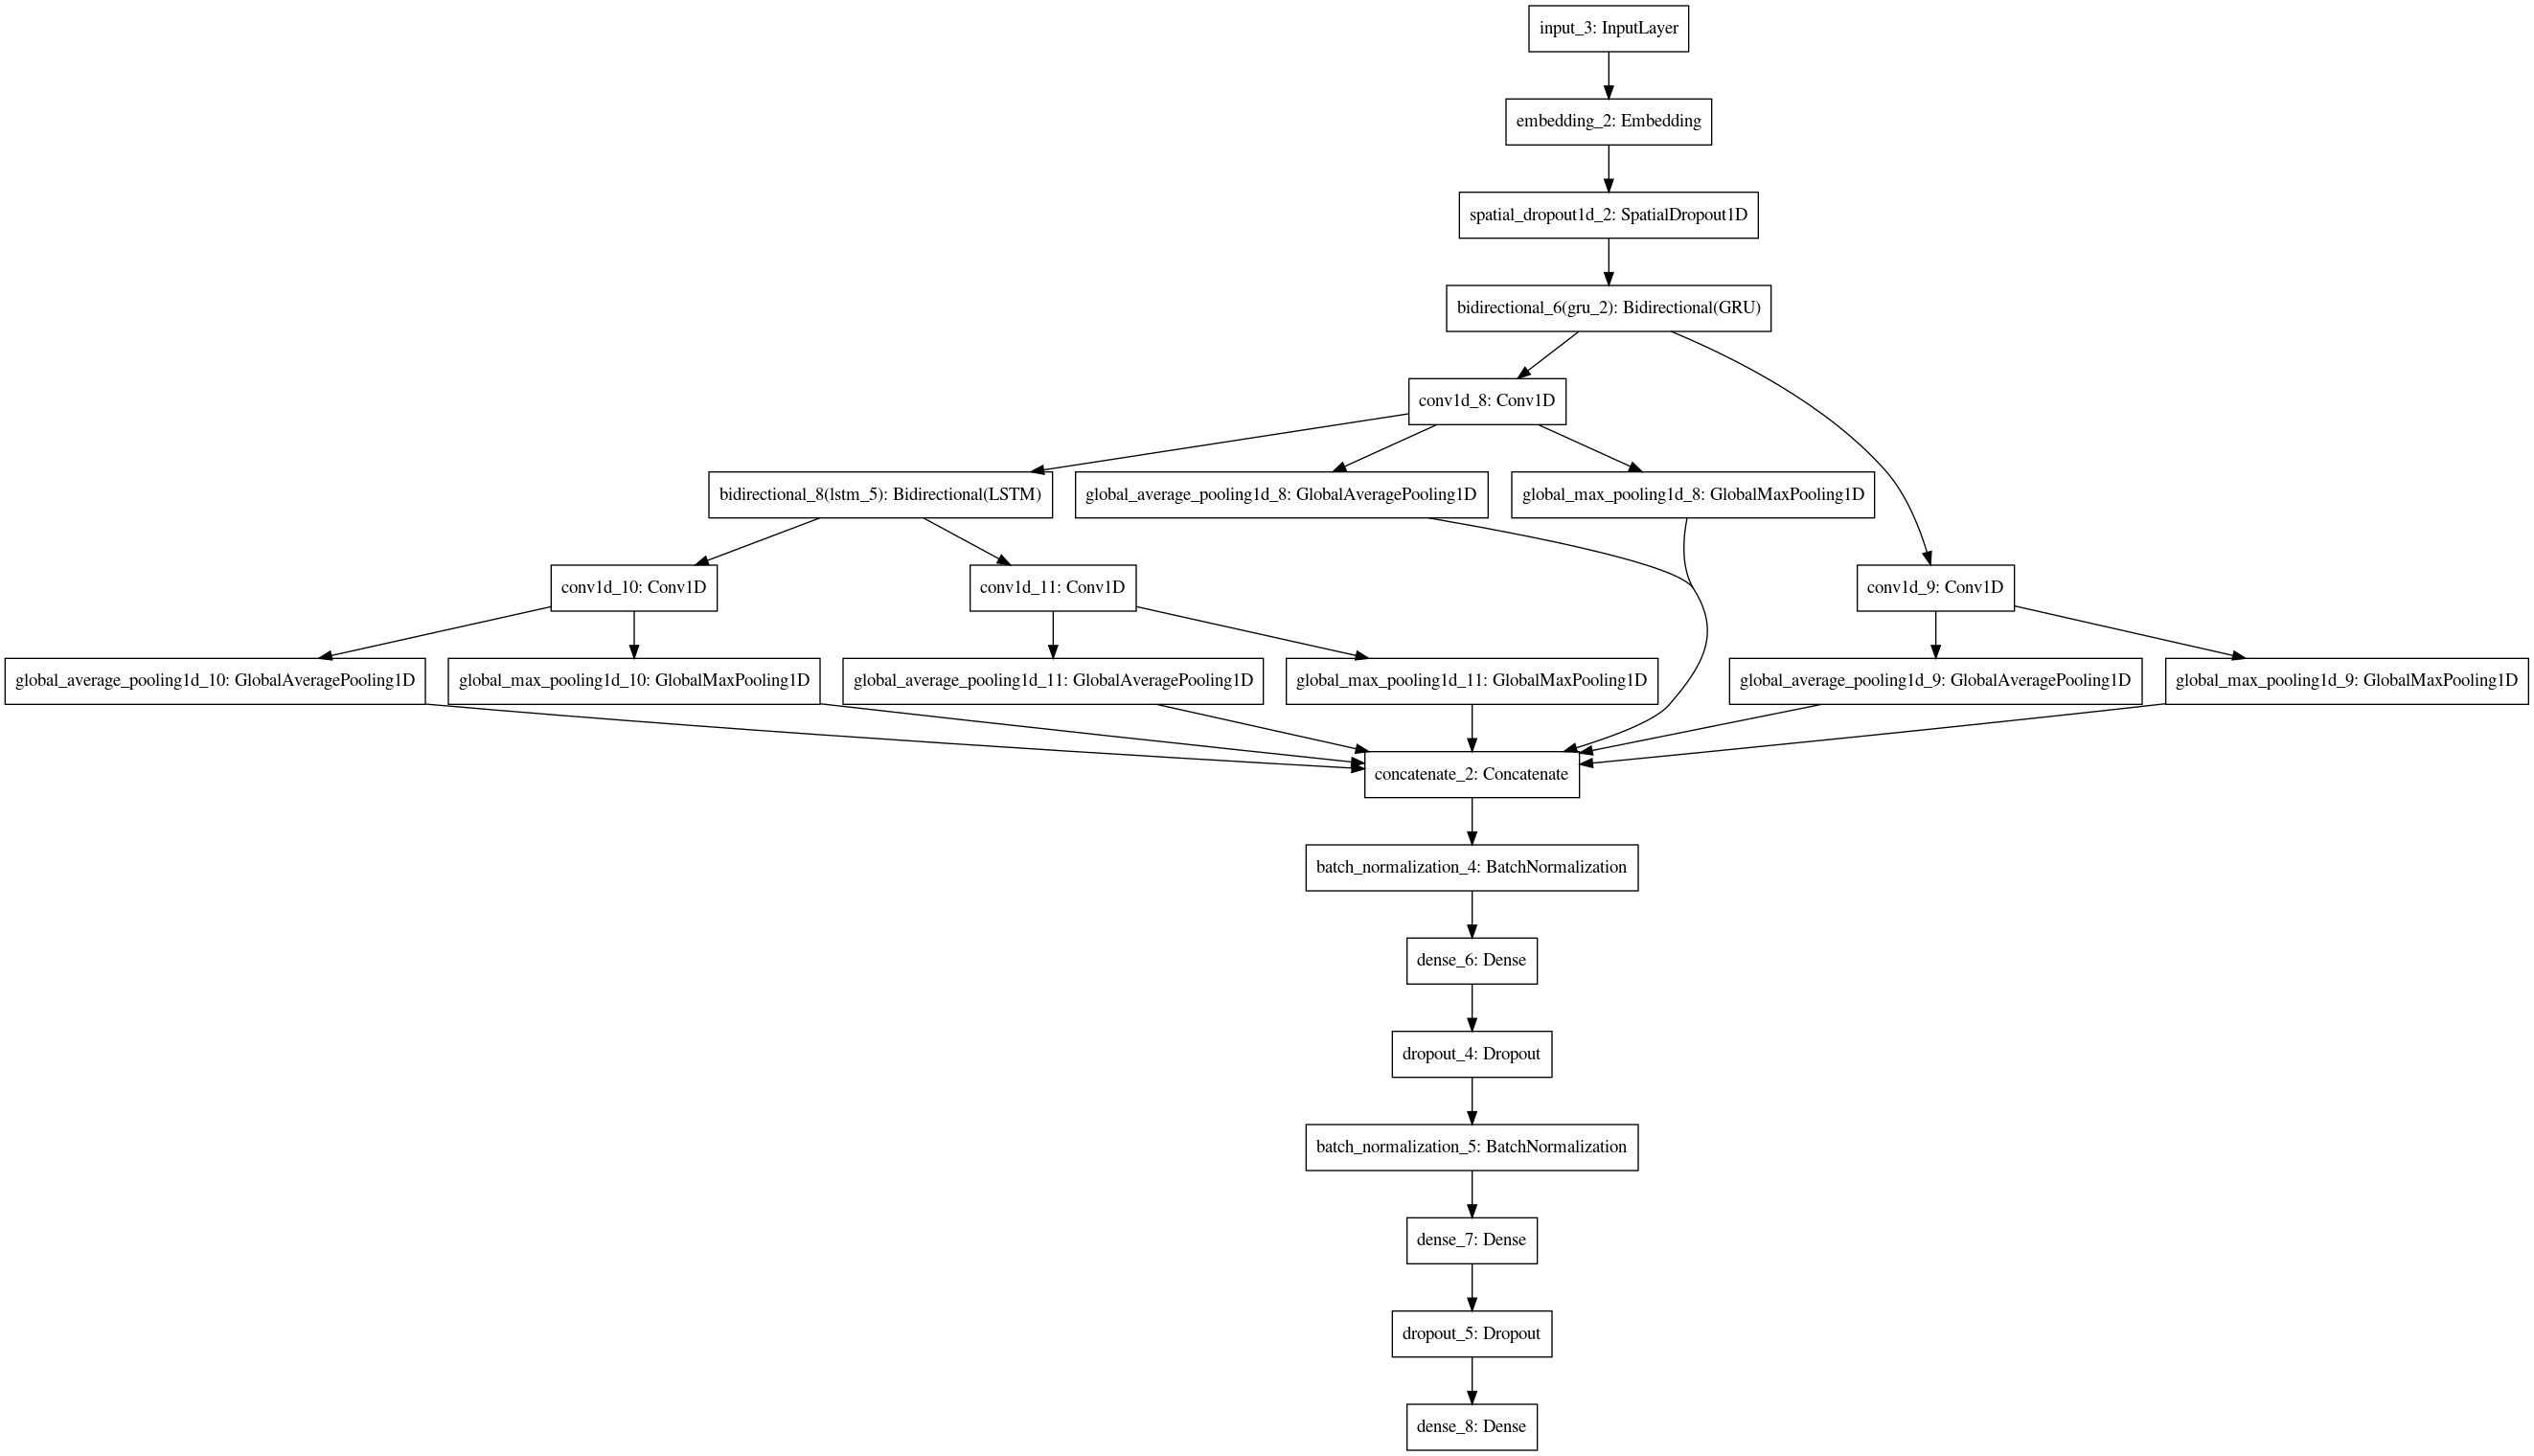

In [56]:
tf.keras.utils.plot_model(model3)

# Evaluate Test dataset on model3

In [57]:
model3.load_weights(file_path3)
score = model3.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

388/388 [==============================] - 17s 45ms/step - loss: 0.7576 - accuracy: 0.8559
Test loss: 0.7575796842575073
Test accuracy: 0.8559096455574036


In [58]:
prediction_value = model3.predict(x_test)
predict_class = np.argmax(prediction_value, axis=-1)
ytest=np.argmax(y_test, axis=1)

In [59]:
# Detailed analysis
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(ytest, predict_class))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       226
           1       0.92      0.79      0.85       197
           2       0.88      0.82      0.85       209
           3       0.61      0.74      0.67       180
           4       0.74      0.73      0.74       200
           5       0.67      0.86      0.75       212
           6       0.96      0.93      0.94       192
           7       0.76      0.76      0.76       200
           8       0.81      0.82      0.81       209
           9       0.96      0.95      0.95       217
          10       0.82      0.87      0.85       177
          11       0.97      0.77      0.86       200
          12       0.93      0.88      0.90       200
          13       0.91      0.81      0.85       207
          14       0.82      0.71      0.76       206
          15       0.76      0.69      0.72       184
          16       0.75      0.83      0.79       207
          17       0.71    

In [60]:
# Confusion matrix for NBSVM Classifier
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [61]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(ytest, predict_class)

Confusion matrix, without normalization
[[203   0   0 ...   0   0   0]
 [  0 155   2 ...   0   0   0]
 [  0   0 171 ...   0   0   2]
 ...
 [  0   0   0 ... 190   0   0]
 [  0   0   0 ...   0 194   0]
 [  0   0   1 ...   0   0 171]]


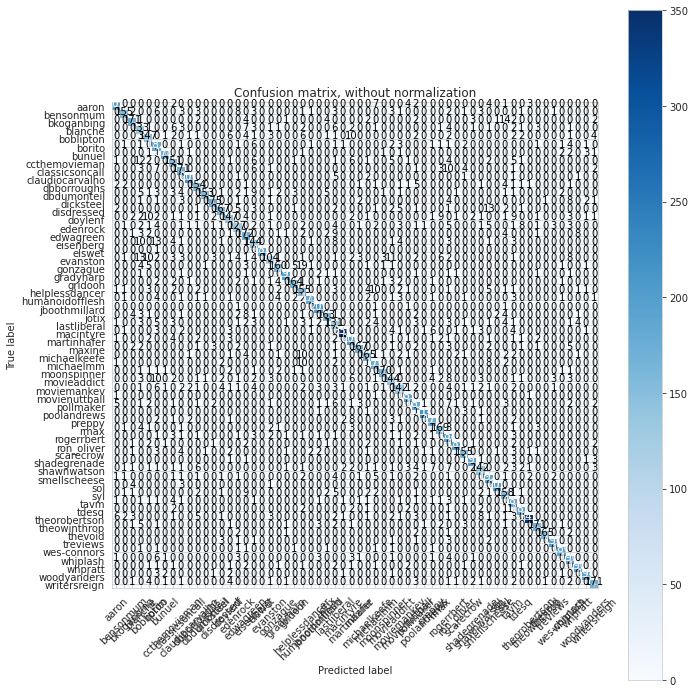

In [62]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['aaron', 'bensonmum', 'bkoganbing', 'blanche', 'boblipton',
       'borito', 'bunuel', 'ccthemovieman', 'classicsoncall',
       'claudiocarvalho', 'dbborroughs', 'dbdumonteil', 'dicksteel',
       'disdressed', 'doylenf', 'edenrock', 'edwagreen', 'eisenberg',
       'elswet', 'evanston', 'gonzague', 'gradyharp', 'gridoon',
       'helplessdancer', 'humanoidofflesh', 'jboothmillard', 'jotix',
       'lastliberal', 'macintyre', 'martinhafer', 'maxine',
       'michaelkeefe', 'michaelmm', 'moonspinner', 'movieaddict',
       'moviemankev', 'movienuttball', 'pollmaker', 'poolandrews',
       'preppy', 'rmax', 'rogerrbert', 'ron_oliver', 'scarecrow',
       'shadegrenade', 'shawnwatson', 'smellscheese', 'sol', 'syl',
       'tavm', 'tdesq', 'theorobertson', 'theowinthrop', 'thevoid',
       'treviews', 'wes-connors', 'whiplash', 'whpratt', 'woodyanders',
       'writersreign'],
                title='Confusion matrix, without normalization')

# Model4

In [63]:
model4 = build_model2(lr = 1e-3, lr_d = 0, units = 64, spatial_dr = 0.5, 
                      kernel_size1=3, kernel_size2=3, dense_units=64, dr=0.3, conv_size=32)

-----------------------------
Processing fold # 0
-----------------------------
Epoch 1/20
775/775 [==============================] - ETA: 0s - loss: 3.4602 - accuracy: 0.1321
Epoch 00001: val_loss did not improve from 0.00192
775/775 [==============================] - 124s 161ms/step - loss: 3.4602 - accuracy: 0.1321 - val_loss: 3.3289 - val_accuracy: 0.1942
Epoch 2/20
775/775 [==============================] - ETA: 0s - loss: 2.1703 - accuracy: 0.3948
Epoch 00002: val_loss did not improve from 0.00192
775/775 [==============================] - 124s 160ms/step - loss: 2.1703 - accuracy: 0.3948 - val_loss: 1.7977 - val_accuracy: 0.4848
Epoch 3/20
775/775 [==============================] - ETA: 0s - loss: 1.6597 - accuracy: 0.5229
Epoch 00003: val_loss did not improve from 0.00192
775/775 [==============================] - 124s 160ms/step - loss: 1.6597 - accuracy: 0.5229 - val_loss: 0.9398 - val_accuracy: 0.7426
Epoch 4/20
775/775 [==============================] - ETA: 0s - loss: 1.37

# Evaluate Test dataset on model4

In [64]:
model4.load_weights(file_path3)
score = model4.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

388/388 [==============================] - 17s 45ms/step - loss: 0.7576 - accuracy: 0.8559
Test loss: 0.7575796842575073
Test accuracy: 0.8559096455574036


In [65]:
prediction_value = model4.predict(x_test)
predict_class = np.argmax(prediction_value, axis=-1)
ytest=np.argmax(y_test, axis=1)

In [66]:
# Detailed analysis
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(ytest, predict_class))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       226
           1       0.92      0.79      0.85       197
           2       0.88      0.82      0.85       209
           3       0.61      0.74      0.67       180
           4       0.74      0.73      0.74       200
           5       0.67      0.86      0.75       212
           6       0.96      0.93      0.94       192
           7       0.76      0.76      0.76       200
           8       0.81      0.82      0.81       209
           9       0.96      0.95      0.95       217
          10       0.82      0.87      0.85       177
          11       0.97      0.77      0.86       200
          12       0.93      0.88      0.90       200
          13       0.91      0.81      0.85       207
          14       0.82      0.71      0.76       206
          15       0.76      0.69      0.72       184
          16       0.75      0.83      0.79       207
          17       0.71    

In [67]:
# Confusion matrix for NBSVM Classifier
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [68]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(ytest, predict_class)

Confusion matrix, without normalization
[[203   0   0 ...   0   0   0]
 [  0 155   2 ...   0   0   0]
 [  0   0 171 ...   0   0   2]
 ...
 [  0   0   0 ... 190   0   0]
 [  0   0   0 ...   0 194   0]
 [  0   0   1 ...   0   0 171]]


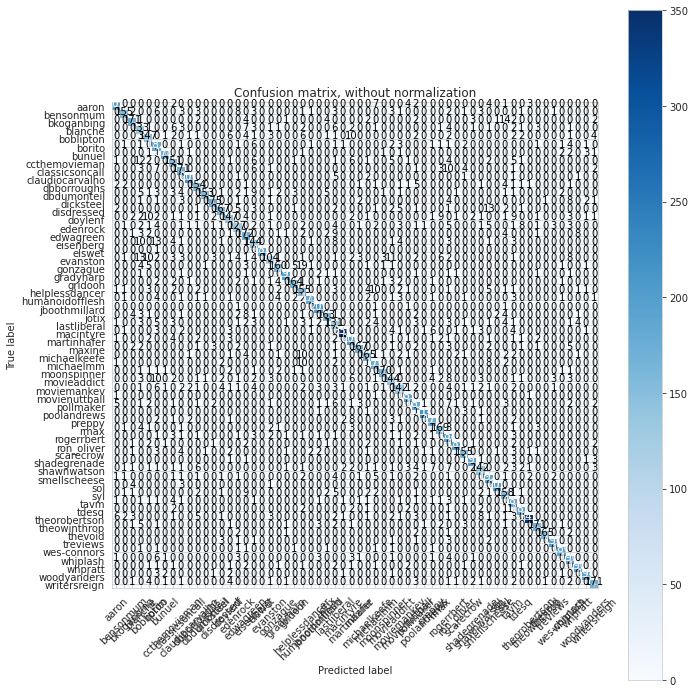

In [69]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['aaron', 'bensonmum', 'bkoganbing', 'blanche', 'boblipton',
       'borito', 'bunuel', 'ccthemovieman', 'classicsoncall',
       'claudiocarvalho', 'dbborroughs', 'dbdumonteil', 'dicksteel',
       'disdressed', 'doylenf', 'edenrock', 'edwagreen', 'eisenberg',
       'elswet', 'evanston', 'gonzague', 'gradyharp', 'gridoon',
       'helplessdancer', 'humanoidofflesh', 'jboothmillard', 'jotix',
       'lastliberal', 'macintyre', 'martinhafer', 'maxine',
       'michaelkeefe', 'michaelmm', 'moonspinner', 'movieaddict',
       'moviemankev', 'movienuttball', 'pollmaker', 'poolandrews',
       'preppy', 'rmax', 'rogerrbert', 'ron_oliver', 'scarecrow',
       'shadegrenade', 'shawnwatson', 'smellscheese', 'sol', 'syl',
       'tavm', 'tdesq', 'theorobertson', 'theowinthrop', 'thevoid',
       'treviews', 'wes-connors', 'whiplash', 'whpratt', 'woodyanders',
       'writersreign'],
                title='Confusion matrix, without normalization')

# Model 5

In [70]:
model5 = build_model2(lr = 1e-3, lr_d = 1e-7, units = 64, spatial_dr = 0.3, 
                      kernel_size1=3, kernel_size2=3, dense_units=64, dr=0.4, conv_size=64)

-----------------------------
Processing fold # 0
-----------------------------
Epoch 1/20
775/775 [==============================] - ETA: 0s - loss: 3.5514 - accuracy: 0.1261
Epoch 00001: val_loss did not improve from 0.00192
775/775 [==============================] - 129s 166ms/step - loss: 3.5514 - accuracy: 0.1261 - val_loss: 3.3631 - val_accuracy: 0.2030
Epoch 2/20
775/775 [==============================] - ETA: 0s - loss: 2.3175 - accuracy: 0.3658
Epoch 00002: val_loss did not improve from 0.00192
775/775 [==============================] - 129s 166ms/step - loss: 2.3175 - accuracy: 0.3658 - val_loss: 1.7787 - val_accuracy: 0.4845
Epoch 3/20
775/775 [==============================] - ETA: 0s - loss: 1.8052 - accuracy: 0.4817
Epoch 00003: val_loss did not improve from 0.00192
775/775 [==============================] - 129s 166ms/step - loss: 1.8052 - accuracy: 0.4817 - val_loss: 1.7954 - val_accuracy: 0.4769
Epoch 4/20
775/775 [==============================] - ETA: 0s - loss: 1.53

# Evaluate Test dataset on model5

In [71]:
model5.load_weights(file_path3)
score = model5.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

388/388 [==============================] - 18s 46ms/step - loss: 0.7576 - accuracy: 0.8559
Test loss: 0.7575796842575073
Test accuracy: 0.8559096455574036


In [72]:
prediction_value = model5.predict(x_test)
predict_class = np.argmax(prediction_value, axis=-1)
ytest=np.argmax(y_test, axis=1)

In [73]:
# Detailed analysis
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(ytest, predict_class))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       226
           1       0.92      0.79      0.85       197
           2       0.88      0.82      0.85       209
           3       0.61      0.74      0.67       180
           4       0.74      0.73      0.74       200
           5       0.67      0.86      0.75       212
           6       0.96      0.93      0.94       192
           7       0.76      0.76      0.76       200
           8       0.81      0.82      0.81       209
           9       0.96      0.95      0.95       217
          10       0.82      0.87      0.85       177
          11       0.97      0.77      0.86       200
          12       0.93      0.88      0.90       200
          13       0.91      0.81      0.85       207
          14       0.82      0.71      0.76       206
          15       0.76      0.69      0.72       184
          16       0.75      0.83      0.79       207
          17       0.71    

In [74]:
# Confusion matrix for NBSVM Classifier
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [75]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(ytest, predict_class)

Confusion matrix, without normalization
[[203   0   0 ...   0   0   0]
 [  0 155   2 ...   0   0   0]
 [  0   0 171 ...   0   0   2]
 ...
 [  0   0   0 ... 190   0   0]
 [  0   0   0 ...   0 194   0]
 [  0   0   1 ...   0   0 171]]


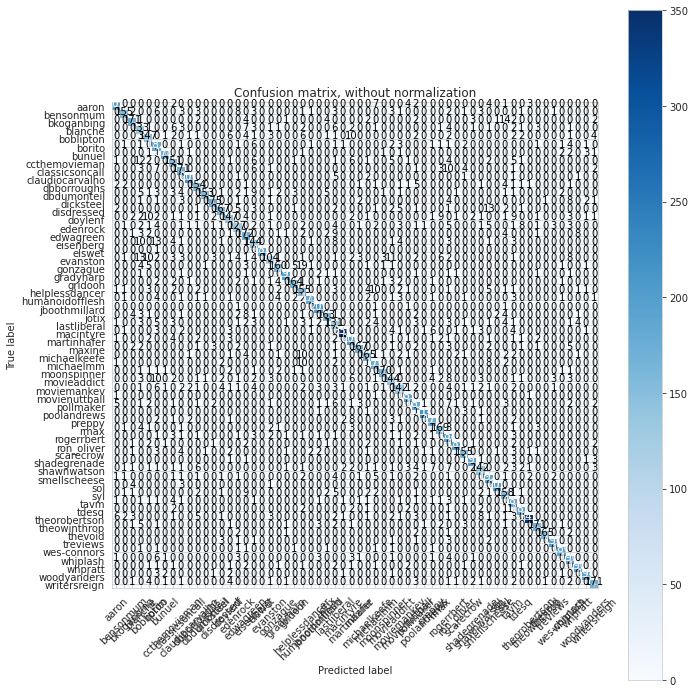

In [76]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['aaron', 'bensonmum', 'bkoganbing', 'blanche', 'boblipton',
       'borito', 'bunuel', 'ccthemovieman', 'classicsoncall',
       'claudiocarvalho', 'dbborroughs', 'dbdumonteil', 'dicksteel',
       'disdressed', 'doylenf', 'edenrock', 'edwagreen', 'eisenberg',
       'elswet', 'evanston', 'gonzague', 'gradyharp', 'gridoon',
       'helplessdancer', 'humanoidofflesh', 'jboothmillard', 'jotix',
       'lastliberal', 'macintyre', 'martinhafer', 'maxine',
       'michaelkeefe', 'michaelmm', 'moonspinner', 'movieaddict',
       'moviemankev', 'movienuttball', 'pollmaker', 'poolandrews',
       'preppy', 'rmax', 'rogerrbert', 'ron_oliver', 'scarecrow',
       'shadegrenade', 'shawnwatson', 'smellscheese', 'sol', 'syl',
       'tavm', 'tdesq', 'theorobertson', 'theowinthrop', 'thevoid',
       'treviews', 'wes-connors', 'whiplash', 'whpratt', 'woodyanders',
       'writersreign'],
                title='Confusion matrix, without normalization')

# Prediction result on test dataset

In [77]:
pred2 = model2.predict(x_test, batch_size = 64, verbose = 1)
pred = pred2
pred3 = model3.predict(x_test, batch_size = 64, verbose = 1)
pred += pred3
pred4 = model4.predict(x_test, batch_size = 64, verbose = 1)
pred += pred4
pred5 = model5.predict(x_test, batch_size = 64, verbose = 1)
pred += pred5

194/194 [==============================] - 10s 54ms/step


In [78]:
# model2.load_weights(file_path)
score = model2.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

388/388 [==============================] - 21s 54ms/step - loss: 0.4832 - accuracy: 0.9061
Test loss: 0.48315179347991943
Test accuracy: 0.9060911536216736


In [79]:
# model3.load_weights(file_path)
score = model3.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

388/388 [==============================] - 17s 45ms/step - loss: 0.7576 - accuracy: 0.8559
Test loss: 0.7575796842575073
Test accuracy: 0.8559096455574036


In [80]:
# model4.load_weights(file_path)
score = model4.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

388/388 [==============================] - 17s 45ms/step - loss: 0.7576 - accuracy: 0.8559
Test loss: 0.7575796842575073
Test accuracy: 0.8559096455574036


In [81]:
# model5.load_weights(file_path)
score = model5.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

388/388 [==============================] - 18s 46ms/step - loss: 0.7576 - accuracy: 0.8559
Test loss: 0.7575796842575073
Test accuracy: 0.8559096455574036


# Attention CNN + BiLSTM

In [34]:
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention

In [35]:
def build_atten_model(max_features, embed_size):
   
    inp = Input(shape = (max_size,))
    x_words = Embedding(max_features, embed_size)(inp)  

    x_words = SpatialDropout1D(0.2)(x_words)
    x_words = Bidirectional(LSTM(128, return_sequences=True))(x_words)
    x_words = Bidirectional(LSTM(128, return_sequences=True))(x_words)
    
    x = SeqWeightedAttention()(x_words)
    
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    pred = Dense(num_of_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=pred)
    return model

In [36]:
model_atten = build_atten_model(max_features, embed_size)
model_atten.compile(loss=loss, optimizer = optimizer, metrics = ["accuracy"])
model_atten.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1163)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1163, 128)         6399872   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 1163, 128)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 1163, 256)         263168    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1163, 256)         394240    
_________________________________________________________________
seq_weighted_attention (SeqW (None, 256)               257       
_________________________________________________________________
dropout (Dropout)            (None, 256)              

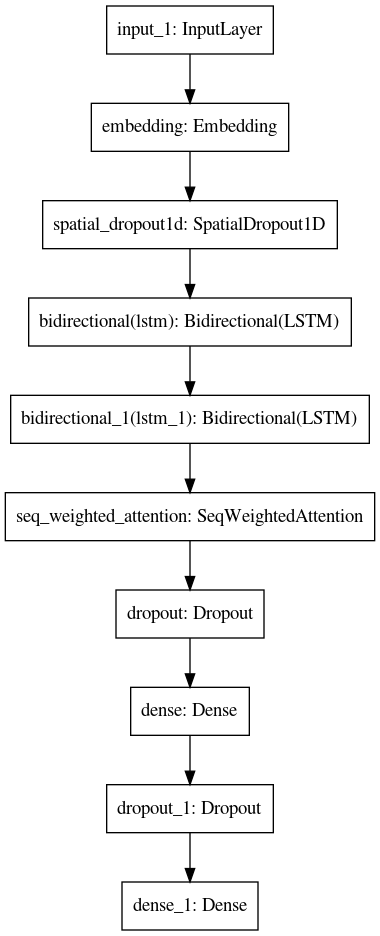

In [37]:
tf.keras.utils.plot_model(model_atten)

In [40]:
model_type6 = "model6"
file_path6 = model_type6 +".weights_base.best.hdf5"

In [41]:
checkpoint6 = ModelCheckpoint(file_path6, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
earlyStopping6 = EarlyStopping(monitor="val_loss", mode="max", patience=es_patience)
csvloggerpath6 = data_dir + 'movie_log6.csv'
csv_logger6 = CSVLogger(csvloggerpath6, append=True, separator=';')
callbacks_list6 = [checkpoint6, earlyStopping6, csv_logger6] 

In [43]:
save_file = 'model_attention.h5'
k = 5
num_validation_sample = len(x_train)//k
for i in range(k):
    print("-----------------------------")
    print('Processing fold #', i)
    print("-----------------------------")
    x_val = x_train[i * num_validation_sample: (i + 1) * num_validation_sample]
    y_val  = y_train[i * num_validation_sample: (i + 1) * num_validation_sample]

    train_x_data = np.concatenate(
                [x_train[:i * num_validation_sample],
                x_train[(i + 1) * num_validation_sample:]], axis=0)

    train_y_label = np.concatenate(
                [y_train[:i * num_validation_sample],
                y_train[(i + 1) * num_validation_sample:]], axis=0)

    history_attention = model_atten.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_data=(x_val, y_val), verbose=1, shuffle=True,
                    callbacks = callbacks_list6)  #callbacks=callbacks_list) #

In [87]:
score = model_atten.evaluate(x_test, y_test, batch_size=batch_size, verbose = 1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

194/194 [==============================] - 13s 67ms/step - loss: 1.3456 - accuracy: 0.7887
Test loss: 1.3456472158432007
Test accuracy: 0.7887051105499268


# Synthetic Approach

After converting the words into embeddings we pass them to our encoder and decoder block. The encoder consists of a bidirectional LSTM layer and another LSTM layer with 128 nodes each. LSTM (Long Short Term Memory) is a type of recurrent neural network introduced by Hochreiter & Schmidhuber (1997). As an RNN it has a word as an input instead of the entire sample as in the case of a standard neural network. This ability makes it flexible to work with different lengths of sentences. The advantage of LSTM against RNN is the ability to capture long range dependencies. Since we are interested in the whole context of a comment that memory is very useful. Bi-Directional brings the ability to work with all available information from the past and the future of a specific time frame (Schuster and Paliwal, 1997). The decoder consists of two LSTM layers also with 128 nodes. Both the encoder and the decoder use dropout to prevent overfitting. Return_sequences is set to true so that the next layer has a three-dimensional sequence as input. Next we give the attention layer as input the output from the encoder and decoder. The output of the attention layer must then be merged with the output of the decoder. Before we can feed the output to our final layer we have to make sure that it has the right shape. Our last layer is the prediction layer using softmax as an activation function.

For the loss function we have chosen categorical crossentropy. It is used in classification problems where only one result can be correct.

Where:

M - number of classes

N - number of samples

ŷ - predicted value

y - true label

log - natural log

i - class

j - sample

Categorical crossentropy compares the distribution of the predictions (the activations in the output layer, one for each class) with the true distribution, where the probability of the true class is set to 1 (our next word) and 0 for the other classes (all the other words). The closer the model’s outputs are to the true class, the lower the loss.

As an optimizer we use Adam optimizer (Adaptive Moment Estimation) which computes adaptive learning rates for each parameter. That algorithm is used for first-order gradient-based optimization of stochastic objective functions (Diederik P. Kingma and Jimmy Ba, 2014). As an evaluation metric we use accuracy.


In [37]:
# https://humboldt-wi.github.io/blog/research/information_systems_1920/text_generation/

In [38]:
inp = Input(shape = (max_size,))

embedding = Embedding(max_features, embed_size)(inp)  

encoder = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(embedding)
encoder = LSTM(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(encoder)

decoder = LSTM(128, recurrent_dropout=0.35, dropout=0.3, return_sequences=True)(embedding)
decoder = LSTM(128, recurrent_dropout=0.35, dropout=0.3, return_sequences=True)(decoder)

attention = Attention()([encoder, decoder])

decoder_concat_input = Concatenate()([decoder, attention])

flatten = Flatten()(decoder_concat_input)

y = Dense(num_of_classes, activation='softmax')(flatten)

model_gen_synthetic = Model(inputs=inp, outputs=y)
model_gen_synthetic.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [39]:
model_gen_synthetic.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1163)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1163, 128)    6399872     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 1163, 128)    131584      embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 1163, 256)    263168      embedding[0][0]                  
_______________________________________________________________________________________

In [40]:
tf.keras.utils.plot_model(model_gen_synthetic)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [45]:
cp = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
ea = EarlyStopping(monitor="val_loss", mode="min", patience=5)
synth_data = data_dir + 'syn_data.csv'
csv_log = CSVLogger(synth_data, append=True, separator=';')
call_backs = [cp,ea,csv_log] 

In [46]:
# model.fit(X_train, y_train, epochs=15, verbose=1, callbacks=[cp,ea], validation_data=(X_valid, y_valid))

In [47]:
# model.evaluate(X_valid, y_valid, batch_size=2048, verbose=1)

In [48]:
k = 5
num_validation_sample = len(x_train)//k
for i in range(k):
    print("-----------------------------")
    print('Processing fold #', i)
    print("-----------------------------")
    x_val = x_train[i * num_validation_sample: (i + 1) * num_validation_sample]
    y_val  = y_train[i * num_validation_sample: (i + 1) * num_validation_sample]

    train_x_data = np.concatenate(
                [x_train[:i * num_validation_sample],
                x_train[(i + 1) * num_validation_sample:]], axis=0)

    train_y_label = np.concatenate(
                [y_train[:i * num_validation_sample],
                y_train[(i + 1) * num_validation_sample:]], axis=0)

    history_attention = model_gen_synthetic.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_data=(x_val, y_val), verbose=1, shuffle=True,callbacks = call_backs)  #callbacks=callbacks_list) #

-----------------------------
Processing fold # 0
-----------------------------
Epoch 1/20
775/775 [==============================] - ETA: 0s - loss: 1.2345 - accuracy: 0.6603
Epoch 00001: val_loss improved from inf to 0.22730, saving model to model1.weights_base.best.hdf5
775/775 [==============================] - 3433s 4s/step - loss: 1.2345 - accuracy: 0.6603 - val_loss: 0.2273 - val_accuracy: 0.9349
Epoch 2/20
775/775 [==============================] - ETA: 0s - loss: 0.2425 - accuracy: 0.9290
Epoch 00002: val_loss improved from 0.22730 to 0.07659, saving model to model1.weights_base.best.hdf5
775/775 [==============================] - 3425s 4s/step - loss: 0.2425 - accuracy: 0.9290 - val_loss: 0.0766 - val_accuracy: 0.9758
Epoch 3/20
775/775 [==============================] - ETA: 0s - loss: 0.1050 - accuracy: 0.9670
Epoch 00003: val_loss improved from 0.07659 to 0.04008, saving model to model1.weights_base.best.hdf5
775/775 [==============================] - 3425s 4s/step - loss:

# Evaluate the model on test data

In [49]:
score = model_gen_synthetic.evaluate(x_test, y_test, batch_size=batch_size, verbose = 1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

194/194 [==============================] - 158s 813ms/step - loss: 0.8335 - accuracy: 0.8898
Test loss: 0.8334810137748718
Test accuracy: 0.8897942900657654
